<h1 align="center"><b>CS116.M11 - LẬP TRÌNH PYTHON CHO MÁY HỌC</b></h1>
<h1 align="center"><b>SUPPORT VECTOR REGRESSION</b></h1>

# **Thông tin nhóm**
1. ***19520227 - Nguyễn Ngọc Lan Phương - 19520227@gm.uit.edu.vn*** 
2. ***19520214 - Cao Hưng Phú - 19520214@gm.uit.edu.vn*** 
3. ***19521216 - Trần Huỳnh Kỳ Anh - 19521216@gm.uit.edu.vn*** 

#1. Cài đặt thư viện cần thiết

In [1]:
!pip install stockai
!pip install ciso8601==2.1.3
!pip install requests==2.25.1
!pip install loguru==0.5.3
!pip install pandas_ta

     |████████████████████████████████| 57 kB 4.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for ciso8601: filename=ciso8601-2.2.0-cp37-cp37m-linux_x86_64.whl size=37537 sha256=180070eb3ceccbbf22007c1a1a454e988d8a244705153f0e40c18929774aced6
  Stored in directory: /root/.cache/pip/wheels/ad/25/8f/3b0a82303191efe3c1204f3741c42d8eb2b0236567e22485de
Successfully built ciso8601
  Created wheel for ciso8601: filename=ciso8601-2.1.3-cp37-cp37m-linux_x86_64.whl size=29120 sha256=014e7b73ae7b6d52c63ae5fad107fbf363370cc0fa0528deafcc3a604ca9e52e
  Stored in directory: /root/.cache/pip/wheels/96/0f/89/b1c8e876a1c8ebf41226adea77b12c4540ffc323006124954d
Successfully built ciso8601
  Attempting uninstall: ciso8601
    Found existing installation: ciso8601 2.2.0
    Uninstalling ciso8601-2.2.0:
      Successfully uninstalled ciso8601-2.2.0
     |████████████████████████████████| 61 kB 5.5 MB/s 
  

In [2]:
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 6.4 MB 19.0 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [3]:
from stockai import Stock
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import sklearn.gaussian_process as gp
import pandas_ta
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.preprocessing import StandardScaler

#2. Thu thập dữ liệu + EDA

In [4]:
import yfinance as yf
from pandas_datareader import data as pdr

#load stock information of SPY
data_train_raw = yf.download('SPY', start='2020-06-01', end="2021-05-30")
data_test_raw = yf.download('SPY', start='2021-06-01', end="2021-11-30")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
data_train = data_train_raw[['Close']]
data_test = data_test_raw[['Close']]

#3. Minh hoạ dữ liệu

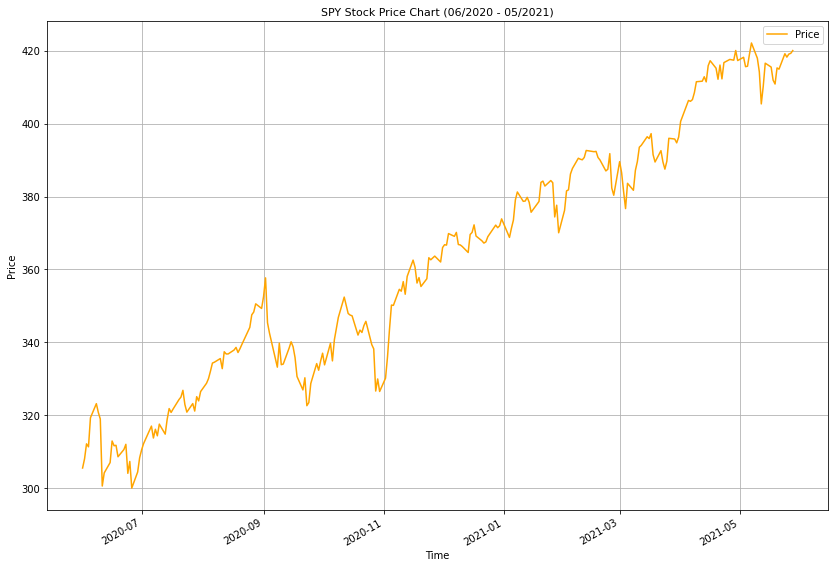

In [6]:
# Visualize data by matpltotlib
stocks_spy = data_train.copy()
plt.figure(figsize=(14,10))
ax1 = stocks_spy.Close.plot(kind = 'line',color = 'orange',label='Close' )
ax1.legend(['Price'])
ax1.set(xlabel="Time", ylabel = 'Price')
plt.title('SPY Stock Price Chart (06/2020 - 05/2021)', fontsize = 11)
plt.grid()
plt.show()

#4. Tiền xử lý dữ liệu
### Để thêm các thuộc tính cho việc dự đoán giá cổ phiếu theo chuỗi thời gian, nhóm quyết định chỉ số Chỉ báo kĩ thuật (Technical Indicator) được định nghĩa là các kinh nghiệm hoặc sự tính toán dựa trên giá, khối lượng hay lãi suất mở của một chứng khoán hoặc một hợp đồng, được những người giao dịch theo phân tích kĩ thuật sử dụng. Đây là một chỉ số có quan hệ chặt chẽ để dự đoán giá cổ phiếu theo thời gian.

In [7]:
data_train.ta.ema(close='Close', length=10, append=True)

Date
2020-06-01           NaN
2020-06-02           NaN
2020-06-03           NaN
2020-06-04           NaN
2020-06-05           NaN
                 ...    
2021-05-24    415.033674
2021-05-25    415.616640
2021-05-26    416.244525
2021-05-27    416.798249
2021-05-28    417.387660
Name: EMA_10, Length: 252, dtype: float64

In [8]:
data_test.ta.ema(close='Close', length=10, append=True)

Date
2021-06-01           NaN
2021-06-02           NaN
2021-06-03           NaN
2021-06-04           NaN
2021-06-07           NaN
                 ...    
2021-11-22    467.179842
2021-11-23    467.363508
2021-11-24    467.741052
2021-11-26    466.146316
2021-11-29    465.865168
Name: EMA_10, Length: 127, dtype: float64

In [9]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2021-06-01 to 2021-11-29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   127 non-null    float64
 1   EMA_10  118 non-null    float64
dtypes: float64(2)
memory usage: 3.0 KB


In [10]:
data_train = data_train.dropna()
data_test = data_test.dropna()

In [11]:
data_train

,Close,EMA_10
Date,,
2020-06-12,304.209991,312.431995
2020-06-15,307.049988,311.453448
2020-06-16,312.959991,311.727365
2020-06-17,311.660004,311.715117
2020-06-18,311.779999,311.726914
...,...,...
2021-05-24,419.170013,415.033674
2021-05-25,418.239990,415.616640
2021-05-26,419.070007,416.244525


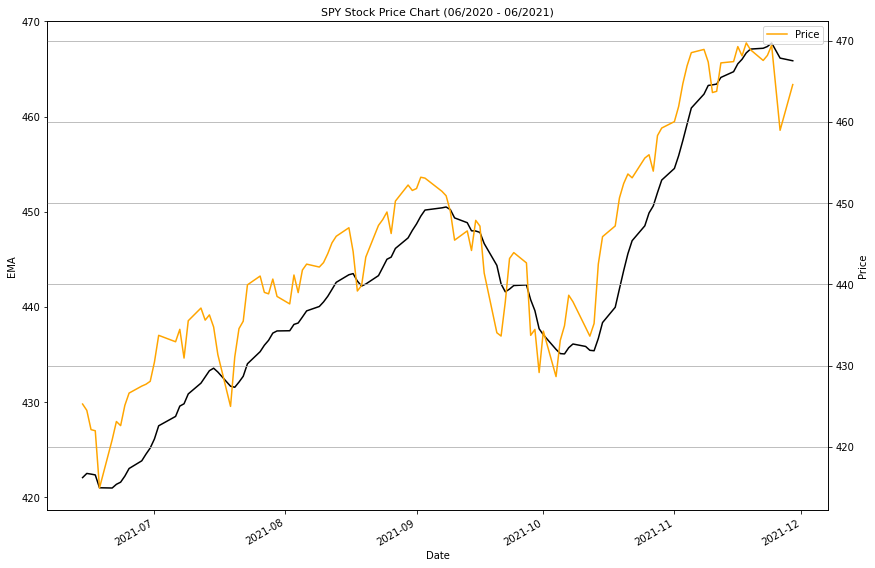

In [12]:
# Visualize data by matpltotlib
stocks_spy = data_test.copy()
plt.figure(figsize=(14,10))
ax = stocks_spy.EMA_10.plot(kind = 'line', color='black', label='EMA')
ax1 = ax.twinx()
ax1 = stocks_spy.Close.plot(kind = 'line',color = 'orange',label='Close' )
ax1.legend(['Price'])
ax.set(ylabel = 'EMA')
ax1.set(xlabel="Time", ylabel = 'Price')
plt.title('SPY Stock Price Chart (06/2020 - 06/2021)', fontsize = 11)
plt.grid()
plt.show()

#5. Phân chia dữ liệu

In [13]:
X_train,  y_train = data_train[['EMA_10']], data_train[['Close']]
X_test, y_test = data_test[['EMA_10']], data_test[['Close']]
print('Kích thước tập dữ liệu train', X_train.shape)
print('Kích thước tập dữ liệu test', X_test.shape)

Kích thước tập dữ liệu train (243, 1)
Kích thước tập dữ liệu test (118, 1)


In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#6. So sánh giữa các mô hình hồi quy với tham số mặc định

##6.1 Mô hình Support Vector Regression

In [15]:
import time

def model(model):
  start_time = time.time()
  model.fit(X_train, y_train)
  done_time = time.time() - start_time
  print('Siêu tham số mặc định của mô hình: ', model.get_params())
  y_pred = model.predict(X_test)
  loss = mean_squared_error(y_pred, y_test)
  return model, y_pred, loss, done_time

In [20]:
def visulizeTest(y_pred, title):
  plt.figure(figsize=(14,10))
  plt.scatter(X_test, y_test)
  plt.plot(X_test, y_pred, 'g-')
  plt.legend(['Grouth_truth', 'Predict'])
  plt.xlabel('EMA_10')
  plt.ylabel('Price')
  plt.title(title)
  plt.show()

###6.1.1 Kernel linear



In [16]:
modelSVR, predSVR, loss, done_time = model(SVR(kernel='linear'))
print('Độ lỗi mô hình SVR trên tập dứ liệu test:', loss)
print('Thời gian thực thi: {:.4f}s'.format(done_time))

Siêu tham số mặc định của mô hình:  {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Độ lỗi mô hình SVR trên tập dứ liệu test: 15.251453806459487
Thời gian thực thi: 0.0060s


###6.1.2 Kernel rbf

In [18]:
modelSVR_rbf, predSVR_rbf, loss_rbf, done_time = model(SVR(kernel='rbf'))
print('Độ lỗi mô hình SVR trên tập dứ liệu test:', loss_rbf)
print('Thời gian thực thi: {:.4f}s'.format(done_time))

Siêu tham số mặc định của mô hình:  {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Độ lỗi mô hình SVR trên tập dứ liệu test: 3982.3633472652505
Thời gian thực thi: 0.0097s


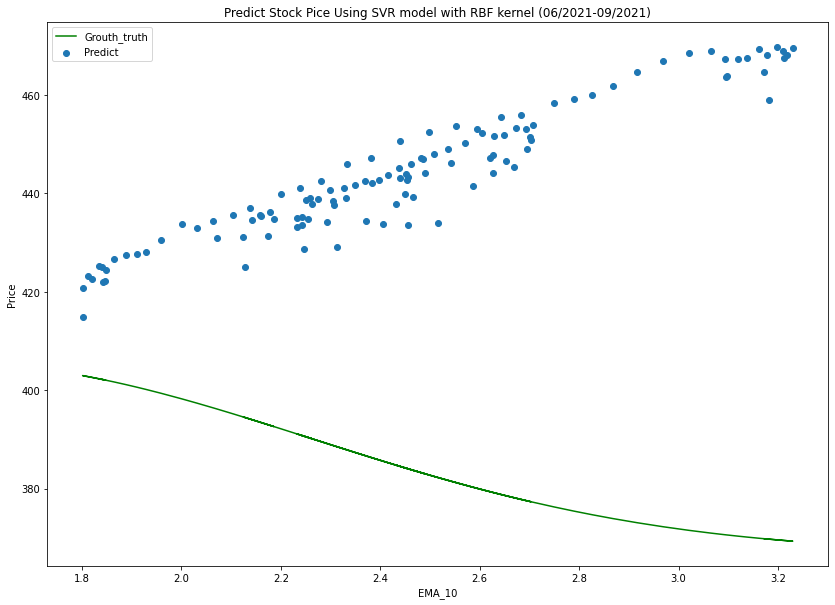

In [22]:
visulizeTest(predSVR_rbf, 'Predict Stock Pice Using SVR model with RBF kernel (06/2021-09/2021)')

###6.1.3 Kernel poly

In [23]:
modelSVR_poly, predSVR_poly, loss_poly, done_time = model(SVR(kernel='poly'))
print('Độ lỗi mô hình SVR trên tập dứ liệu test:', loss_poly)
print('Thời gian thực thi: {:.4f}s'.format(done_time))

Siêu tham số mặc định của mô hình:  {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Độ lỗi mô hình SVR trên tập dứ liệu test: 25683.155830378775
Thời gian thực thi: 0.0076s


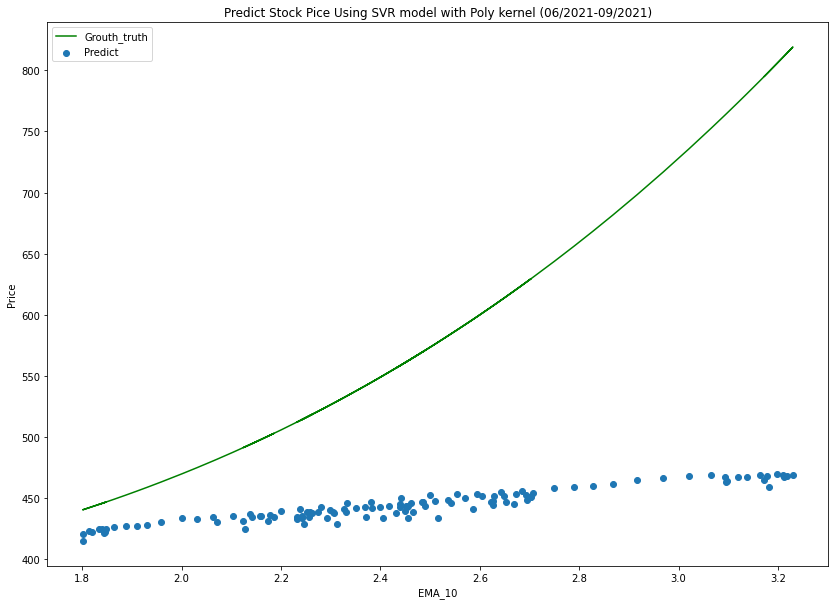

In [24]:
visulizeTest(predSVR_poly, 'Predict Stock Pice Using SVR model with Poly kernel (06/2021-09/2021)')

###6.1.4 Kernel sigmoid

In [25]:
modelSVR_sig, predSVR_sig, loss_sig, done_time = model(SVR(kernel='sigmoid'))
print('Độ lỗi mô hình SVR trên tập dứ liệu test:', loss_sig)
print('Thời gian thực thi: {:.4f}s'.format(done_time))

Siêu tham số mặc định của mô hình:  {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid', 'max_iter': -1, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Độ lỗi mô hình SVR trên tập dứ liệu test: 6315.769456320191
Thời gian thực thi: 0.0086s


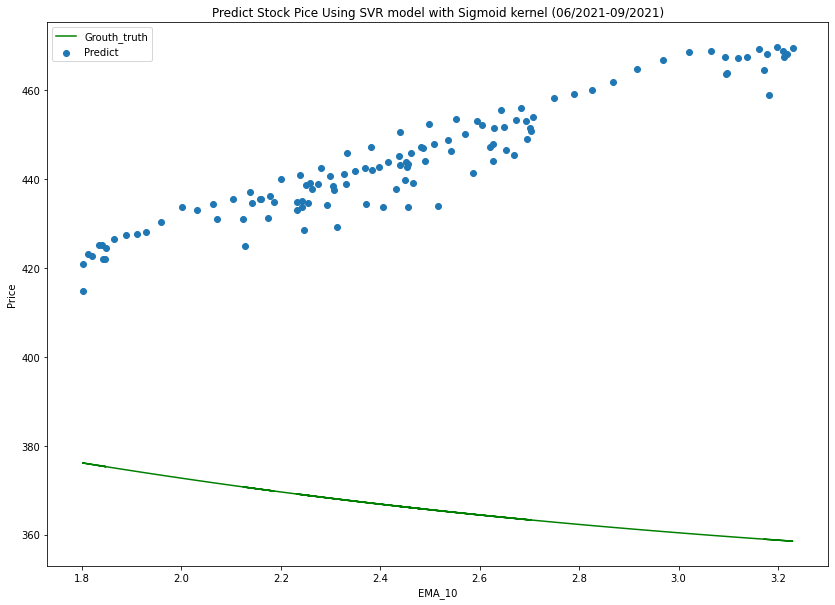

In [26]:
visulizeTest(predSVR_sig, 'Predict Stock Pice Using SVR model with Sigmoid kernel (06/2021-09/2021)')

##6.2 Mô hình Linear Regrssion

In [ ]:
modelLR, predLR, loss, done_time = model(LinearRegression())
print('Độ lỗi mô hình SVR trên tập dứ liệu test:', loss)
print('Thời gian thực thi: {:.4f}s'.format(done_time))

Siêu tham số mặc định của mô hình:  {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': 'deprecated', 'positive': False}
Độ lỗi mô hình SVR trên tập dứ liệu test: 15.944868767907195


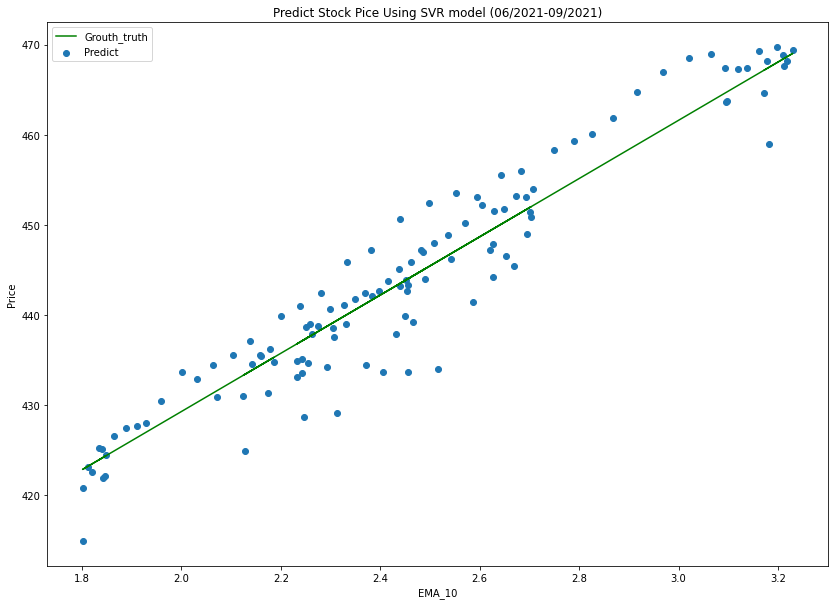

In [ ]:
visulizeTest(predSVR, 'Predict Stock Pice Using SVR model (06/2021-09/2021)')

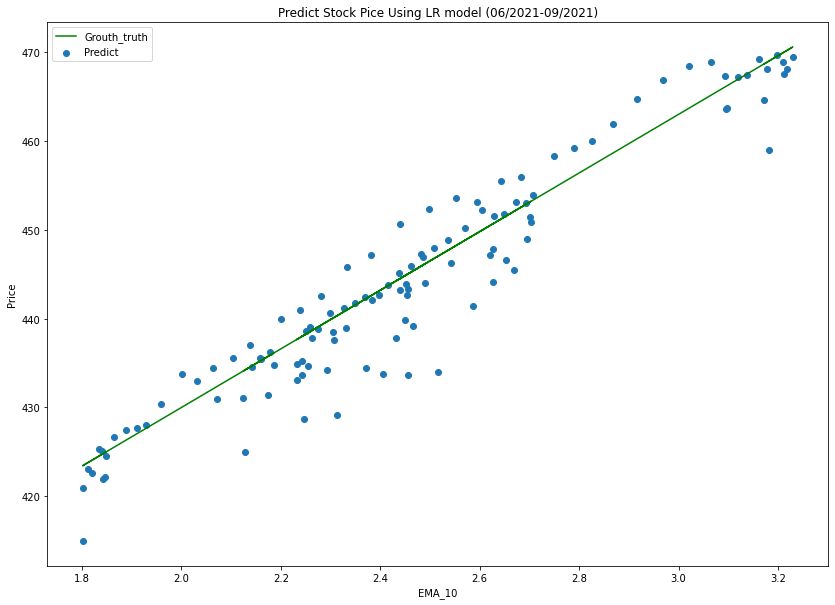

In [ ]:
visulizeTest(predLR, 'Predict Stock Pice Using LR model (06/2021-09/2021)')

## 6.3 Mô hình Ridge Regrssion

In [ ]:
modelRR, predRR, loss, done_time= model(Ridge())
print('Độ lỗi mô hình SVR trên tập dứ liệu test:', loss)
print('Thời gian thực thi: {:.4f}s'.format(done_time))

Siêu tham số mặc định của mô hình:  {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': 'deprecated', 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}
Độ lỗi mô hình SVR trên tập dứ liệu test: 15.45058787852858
Thời gian thực thi: 0.0466s


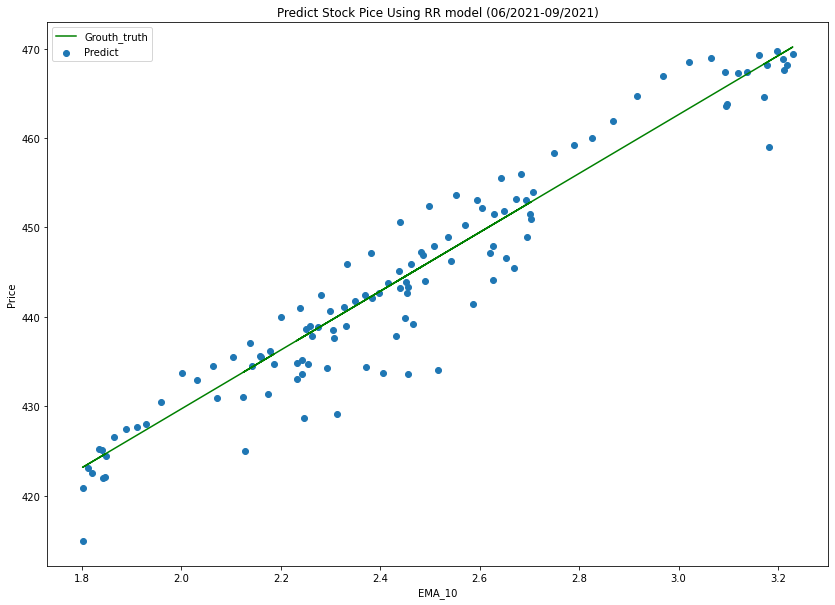

In [ ]:
visulizeTest(predRR, 'Predict Stock Pice Using RR model (06/2021-09/2021)')

## 6.3 Mô hình Lasso Regrssion

In [ ]:
modelRR, predRR, loss, done_time = model(Lasso())
print('Độ lỗi mô hình SVR trên tập dứ liệu test:', loss)
print('Thời gian thực thi: {:.4f}s'.format(done_time))

Siêu tham số mặc định của mô hình:  {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': 'deprecated', 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}
Độ lỗi mô hình SVR trên tập dứ liệu test: 17.634819811421
Thời gian thực thi: 0.0185s


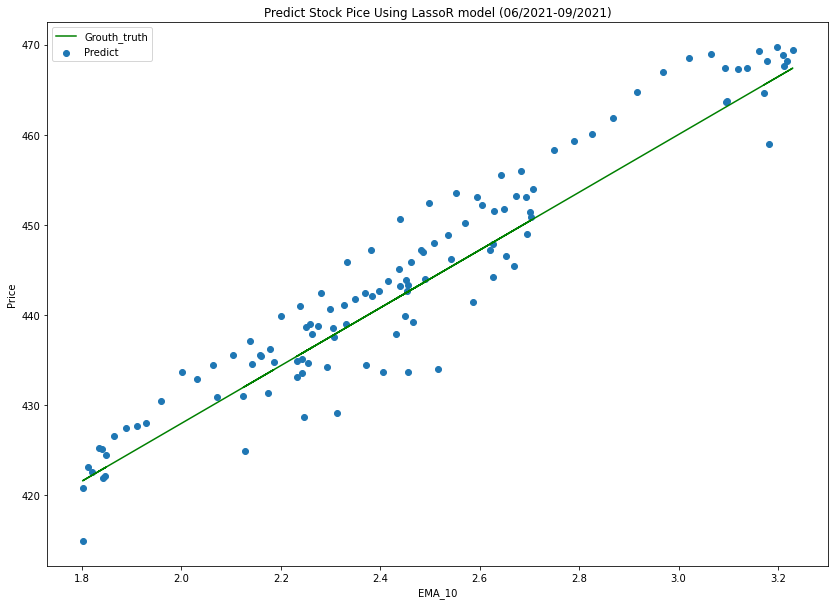

In [ ]:
visulizeTest(predRR, 'Predict Stock Pice Using LassoR model (06/2021-09/2021)')

#7. Điều chỉnh siêu tham số của mô hình SVR

In [ ]:
list_c = [0.1, 1.0, 10.0, 100.0]
list_epsilon = [0.0, 0.01, 0.1, 0.3, 0.5]
list_kernel =  ['poly', 'rbf', 'linear', 'sigmoid']
list_gamma = [0.1, 0.01, 0.001, 0.0001]
list_degree =  [1, 2, 3, 4]
list_coef0 = [0.0, 0.1, 0.3, 0.5, 1]

##7.1 Sử dụng vòng lặp for

In [ ]:
import sys

for_best_param = {
    'kernel': None,
    'C': None, 
    'epsilon': None,
    'gamma': None
}

for_best_mse = sys.maxsize

modelForSearch = None

In [ ]:
temp_best_param = {
    'kernel': None,
    'C': None, 
    'epsilon': None,
    'gamma': None
}

start_time_begin = time.time()
for kernel in list_kernel:
  for C in list_c:
    for epsilon in list_epsilon:
      for gamma in list_gamma:
        temp_param = {
            'kernel': kernel,
            'C': C, 
            'epsilon': epsilon,
            'gamma': gamma
        }
        print("[=> Config: ", temp_param)
        model = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma)
        start_time = time.time()
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        temp_mse = mean_squared_error(y_test, y_predict)
        print("-> MSE:", temp_mse)
        print("-> Time: {:.4f}s".format(time.time() - start_time))
        if temp_mse < for_best_mse:
          for_best_param = temp_param
          for_best_mse = temp_mse
          modelForSearch = model
        print("============================================")
done_time_end = time.time() - start_time_begin

[=> Config:  {'kernel': 'poly', 'C': 0.1, 'epsilon': 0.0, 'gamma': 0.1}
-> MSE: 6148.481094917866
-> Time: 0.0250s
[=> Config:  {'kernel': 'poly', 'C': 0.1, 'epsilon': 0.0, 'gamma': 0.01}
-> MSE: 6232.772957195867
-> Time: 0.0271s
[=> Config:  {'kernel': 'poly', 'C': 0.1, 'epsilon': 0.0, 'gamma': 0.001}
-> MSE: 6232.857561165776
-> Time: 0.0256s
[=> Config:  {'kernel': 'poly', 'C': 0.1, 'epsilon': 0.0, 'gamma': 0.0001}
-> MSE: 6232.8576457700965
-> Time: 0.0186s
[=> Config:  {'kernel': 'poly', 'C': 0.1, 'epsilon': 0.01, 'gamma': 0.1}
-> MSE: 6148.481094917866
-> Time: 0.0260s
[=> Config:  {'kernel': 'poly', 'C': 0.1, 'epsilon': 0.01, 'gamma': 0.01}
-> MSE: 6232.772957195888
-> Time: 0.0175s
[=> Config:  {'kernel': 'poly', 'C': 0.1, 'epsilon': 0.01, 'gamma': 0.001}
-> MSE: 6232.857561165765
-> Time: 0.0251s
[=> Config:  {'kernel': 'poly', 'C': 0.1, 'epsilon': 0.01, 'gamma': 0.0001}
-> MSE: 6232.8576457700965
-> Time: 0.0188s
[=> Config:  {'kernel': 'poly', 'C': 0.1, 'epsilon': 0.1, 'gam

In [ ]:
print("Best Parameters:", for_best_param)
print("Best MSE:", for_best_mse)
print('Thời gian thực thi: {:.4f}s'.format(done_time_end))

Best Parameters: {'kernel': 'linear', 'C': 1.0, 'epsilon': 0.0, 'gamma': 0.1}
Best MSE: 15.243495652367173
Thời gian thực thi: 5.5199s


##7.2 Sử dụng Grid Search

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

tuned_parameters = [
    {"kernel": ["rbf", "linear"], "C": list_c, "epsilon": list_epsilon, "gamma": list_gamma},
    {"kernel": ["poly"], "C": list_c, "epsilon": list_epsilon, "gamma": list_gamma, "degree": list_degree, "coef0": list_coef0},
    {"kernel": ["sigmoid"], "C": list_c, "epsilon": list_epsilon, "gamma": list_gamma, "coef0": list_coef0}
]

In [ ]:
def mse_custom_scoring(y_true, y_predict):
  return mean_squared_error(y_true, y_predict)

MSE_scoring = make_scorer(mse_custom_scoring, greater_is_better=False)

In [ ]:
from sklearn.model_selection import GridSearchCV
start_time = time.time()
modelGridSearch = GridSearchCV(SVR(), tuned_parameters, scoring=MSE_scoring, verbose=3)
modelGridSearch.fit(X_train, y_train)
done_time = time.time() - start_time

Streaming output truncated to the last 5000 lines.
[CV 1/5] END C=10.0, coef0=0.3, degree=3, epsilon=0.0, gamma=0.1, kernel=poly;, score=-323.653 total time=   0.0s
[CV 2/5] END C=10.0, coef0=0.3, degree=3, epsilon=0.0, gamma=0.1, kernel=poly;, score=-77.741 total time=   0.0s
[CV 3/5] END C=10.0, coef0=0.3, degree=3, epsilon=0.0, gamma=0.1, kernel=poly;, score=-16.336 total time=   0.0s
[CV 4/5] END C=10.0, coef0=0.3, degree=3, epsilon=0.0, gamma=0.1, kernel=poly;, score=-27.759 total time=   0.0s
[CV 5/5] END C=10.0, coef0=0.3, degree=3, epsilon=0.0, gamma=0.1, kernel=poly;, score=-340.659 total time=   0.0s
[CV 1/5] END C=10.0, coef0=0.3, degree=3, epsilon=0.0, gamma=0.01, kernel=poly;, score=-2364.266 total time=   0.0s
[CV 2/5] END C=10.0, coef0=0.3, degree=3, epsilon=0.0, gamma=0.01, kernel=poly;, score=-964.541 total time=   0.0s
[CV 3/5] END C=10.0, coef0=0.3, degree=3, epsilon=0.0, gamma=0.01, kernel=poly;, score=-121.473 total time=   0.0s
[CV 4/5] END C=10.0, coef0=0.3, degr

In [ ]:
print("Best params:", modelGridSearch.best_params_ )
print("Best MSE:", abs(modelGridSearch.best_score_))
print('Thời gian thực thi: {:.4f}s'.format(done_time))

Best params: {'C': 100.0, 'epsilon': 0.5, 'gamma': 0.1, 'kernel': 'linear'}
Best MSE: 15.243495652367173
Thời gian thực thi: 85.5265s


##7.3 Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
start_time = time.time()
modelRandomSearch = RandomizedSearchCV(SVR(), tuned_parameters, scoring=MSE_scoring, verbose=3)
modelRandomSearch.fit(X_train, y_train)
done_time = time.time() - start_time

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END C=1.0, coef0=1, degree=3, epsilon=0.0, gamma=0.01, kernel=poly;, score=-2287.676 total time=   0.0s
[CV 2/5] END C=1.0, coef0=1, degree=3, epsilon=0.0, gamma=0.01, kernel=poly;, score=-928.634 total time=   0.0s
[CV 3/5] END C=1.0, coef0=1, degree=3, epsilon=0.0, gamma=0.01, kernel=poly;, score=-115.027 total time=   0.0s
[CV 4/5] END C=1.0, coef0=1, degree=3, epsilon=0.0, gamma=0.01, kernel=poly;, score=-904.785 total time=   0.0s
[CV 5/5] END C=1.0, coef0=1, degree=3, epsilon=0.0, gamma=0.01, kernel=poly;, score=-2916.460 total time=   0.0s
[CV 1/5] END C=1.0, coef0=0.0, degree=2, epsilon=0.3, gamma=0.0001, kernel=poly;, score=-3028.315 total time=   0.0s
[CV 2/5] END C=1.0, coef0=0.0, degree=2, epsilon=0.3, gamma=0.0001, kernel=poly;, score=-1300.465 total time=   0.0s
[CV 3/5] END C=1.0, coef0=0.0, degree=2, epsilon=0.3, gamma=0.0001, kernel=poly;, score=-188.133 total time=   0.0s
[CV 4/5] END C=1.0, coef0=0

In [ ]:
print("Best params:", modelRandomSearch.best_params_ )
print("Best MSE:", abs(modelRandomSearch.best_score_))
print('Thời gian thực thi: {:.4f}s'.format(done_time))

Best params: {'kernel': 'poly', 'gamma': 0.01, 'epsilon': 0.0, 'degree': 2, 'coef0': 1, 'C': 100.0}
Best MSE: 15.263565662239337
Thời gian thực thi: 0.3105s


##7.4 Bayes Optimization

In [ ]:
!pip install scikit-optimize

     |████████████████████████████████| 100 kB 8.7 MB/s 


In [ ]:
from skopt import BayesSearchCV
start_time = time.time()
modelBayesSearch = BayesSearchCV(SVR(), tuned_parameters, scoring=MSE_scoring, verbose=3)
modelBayesSearch.fit(X_train, y_train)
done_time = time.time() - start_time

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=1.0, epsilon=0.5, gamma=0.1, kernel=linear;, score=-19.037 total time=   0.0s
[CV 2/5] END C=1.0, epsilon=0.5, gamma=0.1, kernel=linear;, score=-43.312 total time=   0.0s
[CV 3/5] END C=1.0, epsilon=0.5, gamma=0.1, kernel=linear;, score=-15.812 total time=   0.0s
[CV 4/5] END C=1.0, epsilon=0.5, gamma=0.1, kernel=linear;, score=-16.114 total time=   0.0s
[CV 5/5] END C=1.0, epsilon=0.5, gamma=0.1, kernel=linear;, score=-16.177 total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=10.0, epsilon=0.1, gamma=0.001, kernel=rbf;, score=-2512.906 total time=   0.0s
[CV 2/5] END C=10.0, epsilon=0.1, gamma=0.001, kernel=rbf;, score=-1044.669 total time=   0.0s
[CV 3/5] END C=10.0, epsilon=0.1, gamma=0.001, kernel=rbf;, score=-137.379 total time=   0.0s
[CV 4/5] END C=10.0, epsilon=0.1, gamma=0.001, kernel=rbf;, score=-1034.409 total time=   0.0s
[CV 5/5] END C=10.0, epsilon=0.1, gamm

In [ ]:
print("Best params:", modelBayesSearch.best_params_)
print("Best MSE:", abs(modelBayesSearch.best_score_))
print('Thời gian thực thi: {:.4f}s'.format(done_time))

Best params: OrderedDict([('C', 100.0), ('epsilon', 0.5), ('gamma', 0.01), ('kernel', 'linear')])
Best MSE: 15.554464123367595
Thời gian thực thi: 314.9334s
